In [1]:
import os
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True


# Loading Data

In [2]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ["Normal cases", "Benign cases", "Malignant cases"]  # List the directories (class folders)
        self.image_paths = []  # Store the paths of images
        self.labels = []       # Store the labels corresponding to images

        for label, class_name in enumerate(self.classes): # for each class (Normal = 0, Benign = 1, Malignant = 2)
            class_folder = os.path.join(data_dir, class_name)
            if os.path.isdir(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.jpg', '.png', '.jpeg')):  # image datatypes
                        self.image_paths.append(os.path.join(class_folder, file_name)) # append images
                        self.labels.append(label) # append associated labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = PIL.Image.open(img_path)

        # Apply any transformations (if defined)
        if self.transform:
            image = self.transform(image)

        # Return the image and the label
        label = self.labels[idx]
        return image, label



In [3]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)), # resizing. some images are not 512x512
    transforms.Grayscale(),
    transforms.ToTensor()   # convert image to a tensor
])


cancer_dataset = CancerDataset("../data", img_transform)
print(f'Img Shape: {cancer_dataset[0][0].shape}')

print(f'Dataset Size: {len(cancer_dataset)}')
label_map = {0 : "Normal", 1 : "Benign", 2 : "Malignant"}
cts = np.unique(cancer_dataset.labels, return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'{label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(cancer_dataset):.2f}')

Img Shape: torch.Size([1, 512, 512])
Dataset Size: 1097
Normal Count: 416, Percent: 37.92
Benign Count: 120, Percent: 10.94
Malignant Count: 561, Percent: 51.14


In [4]:
torch.manual_seed(35)  # set seed

train_proportion = 0.7 # percent training set

train_size = int(train_proportion * len(cancer_dataset)) 
test_size = len(cancer_dataset) - train_size 

train_dataset, test_dataset = random_split(cancer_dataset, [train_size, test_size]) # split dataset into train and test

In [5]:
print(f'Test Set Size: {len(test_dataset.indices)}')
cts = np.unique([cancer_dataset[i][1] for i in test_dataset.indices], return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'Test {label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(test_dataset.indices):.2f}')

Test Set Size: 330
Test Normal Count: 130, Percent: 39.39
Test Benign Count: 37, Percent: 11.21
Test Malignant Count: 163, Percent: 49.39


In [6]:
# initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modeling

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.linear = nn.Linear(32*64*64, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.relu(self.conv1(x))) # 256x256
        x = self.pool(F.relu(self.conv2(x))) # 128x128
        x = self.pool(F.relu(self.conv3(x))) # 64x64

        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [8]:
model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [9]:
results = []
for epoch in range(1, num_epochs+1):
    model.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])
    if i%2 == 0:
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}")



Epoch 1/20: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


Train Loss: 0.9298
Valid Loss: 0.7881


Epoch 2/20: 100%|██████████| 24/24 [00:20<00:00,  1.14it/s]


Train Loss: 0.5796
Valid Loss: 0.5472


Epoch 3/20: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


Train Loss: 0.3090
Valid Loss: 0.2479


Epoch 4/20: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


Train Loss: 0.1407
Valid Loss: 0.1457


Epoch 5/20: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Train Loss: 0.0754
Valid Loss: 0.0820


Epoch 6/20: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


Train Loss: 0.0652
Valid Loss: 0.1368


Epoch 7/20: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Train Loss: 0.0443
Valid Loss: 0.0816


Epoch 8/20: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Train Loss: 0.0447
Valid Loss: 0.0574


Epoch 9/20: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


Train Loss: 0.0215
Valid Loss: 0.0696


Epoch 10/20: 100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


Train Loss: 0.0174
Valid Loss: 0.0512


Epoch 11/20: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Train Loss: 0.0373
Valid Loss: 0.1286


Epoch 12/20: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Train Loss: 0.0118
Valid Loss: 0.0339


Epoch 13/20: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Train Loss: 0.0120
Valid Loss: 0.0626


Epoch 14/20: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Train Loss: 0.0179
Valid Loss: 0.0385


Epoch 15/20: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Train Loss: 0.0297
Valid Loss: 0.1535


Epoch 16/20: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Train Loss: 0.0181
Valid Loss: 0.0507


Epoch 17/20: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train Loss: 0.0065
Valid Loss: 0.0655


Epoch 18/20: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Train Loss: 0.0060
Valid Loss: 0.0358


Epoch 19/20: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Train Loss: 0.0056
Valid Loss: 0.0352


Epoch 20/20: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Train Loss: 0.0079
Valid Loss: 0.0468


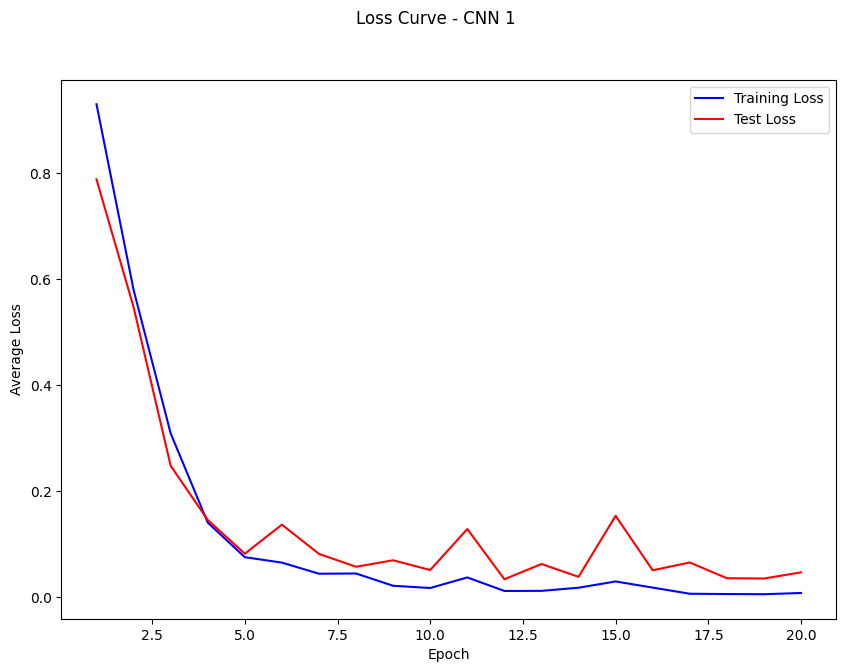

In [10]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - CNN 1')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [11]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9848484848484849
Overall ROC AUC: 0.9994822906392873
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       130
           1       1.00      0.86      0.93        37
           2       1.00      1.00      1.00       163

    accuracy                           0.98       330
   macro avg       0.99      0.95      0.97       330
weighted avg       0.99      0.98      0.98       330



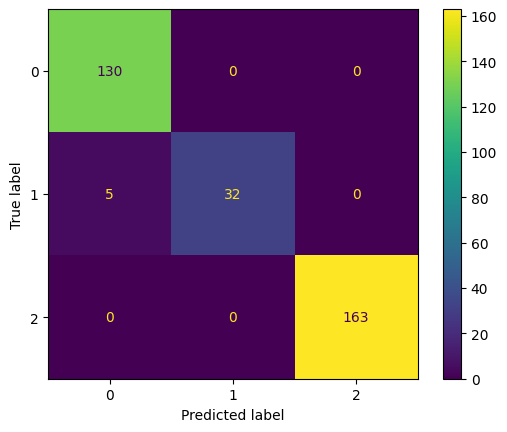

In [ ]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))    

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## CNN 2

In [13]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.linear1 = nn.Linear(32*64*64, 128)
        self.linear2 = nn.Linear(128, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.relu(self.conv1(x))) # 256x256
        x = self.pool(F.relu(self.conv2(x))) # 128x128
        x = self.pool(F.relu(self.conv3(x))) # 64x64

        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [14]:
model2 = CNN2() # 2 dense layers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [15]:
results = []
for epoch in range(1, num_epochs+1):
    model2.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model2.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model2(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])



Epoch 20/20: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


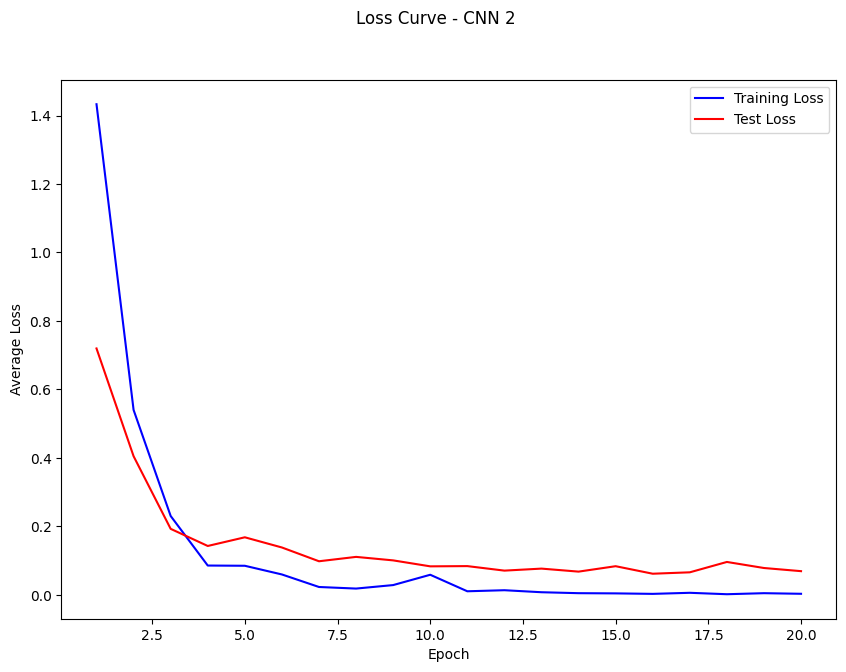

In [16]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - CNN 2')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [17]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model2(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9818181818181818
Overall ROC AUC: 0.9980505550792095
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       130
           1       1.00      0.86      0.93        37
           2       0.99      1.00      0.99       163

    accuracy                           0.98       330
   macro avg       0.99      0.95      0.97       330
weighted avg       0.98      0.98      0.98       330



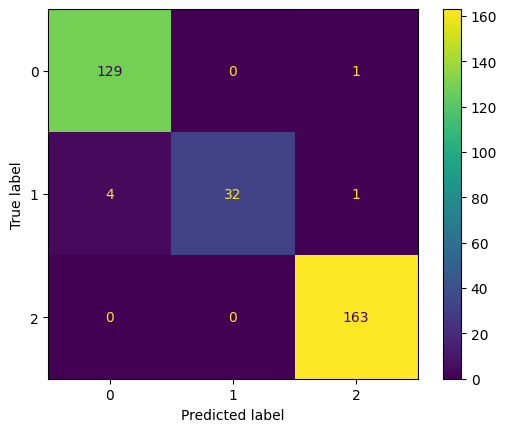

In [18]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## CNN 3

In [19]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)


        self.linear = nn.Linear(64*32*32, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.relu(self.conv1(x))) # 256x256
        x = self.pool(F.relu(self.conv2(x))) # 128x128
        x = self.pool(F.relu(self.conv3(x))) # 64x64
        x = self.pool(F.relu(self.conv4(x))) # 32x32


        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [20]:
model3 = CNN3() # 2 dense layers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [21]:
results = []
for epoch in range(1, num_epochs+1):
    model3.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model3(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model3.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model3(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])



Epoch 20/20: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


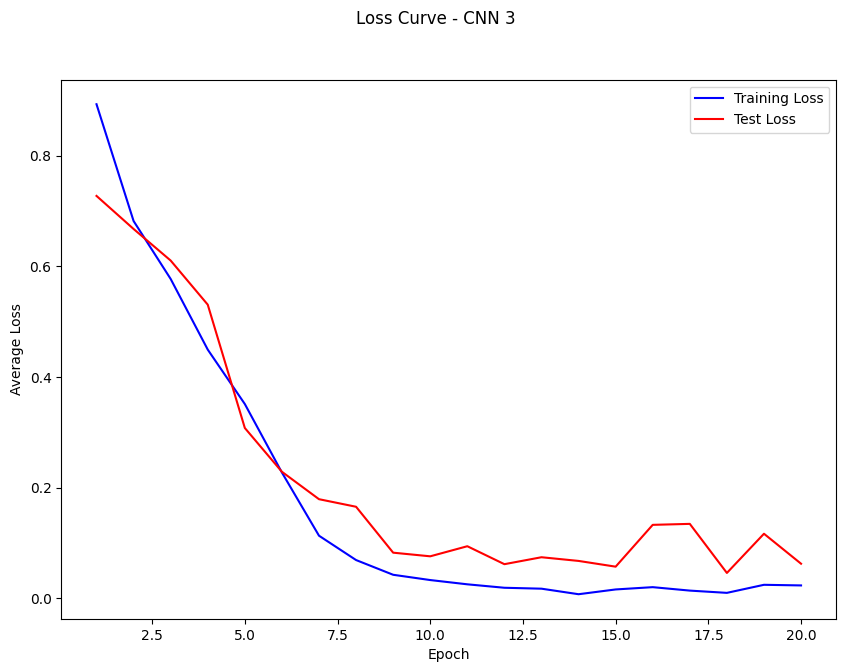

In [22]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))      
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - CNN 3')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [23]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model3(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9757575757575757
Overall ROC AUC: 0.9984852246575796
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       130
           1       0.94      0.89      0.92        37
           2       0.99      1.00      0.99       163

    accuracy                           0.98       330
   macro avg       0.97      0.95      0.96       330
weighted avg       0.98      0.98      0.98       330



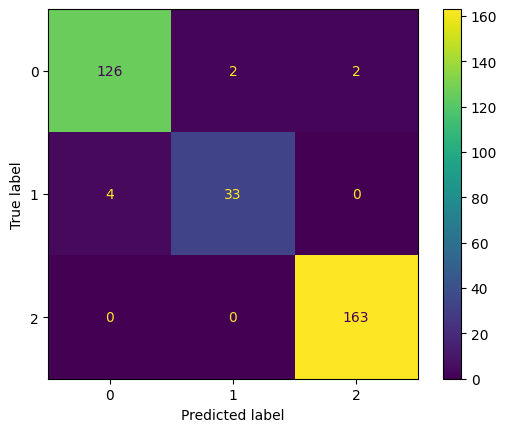

In [24]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Base CNN

In [15]:
class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.linear = nn.Linear(16*128*128, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.relu(self.conv1(x))) # 256x256
        x = self.pool(F.relu(self.conv2(x))) # 128x128


        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [16]:
model_base = Base_CNN() # 2 dense layers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model_base.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [17]:
results = []
for epoch in range(1, num_epochs+1):
    model_base.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_base(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model_base.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model_base(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])



Epoch 20/20: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


In [18]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model_base(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9878787878787879
Overall ROC AUC: 0.9987730662488197
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       130
           1       0.97      0.95      0.96        37
           2       0.99      1.00      0.99       163

    accuracy                           0.99       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.99      0.99      0.99       330



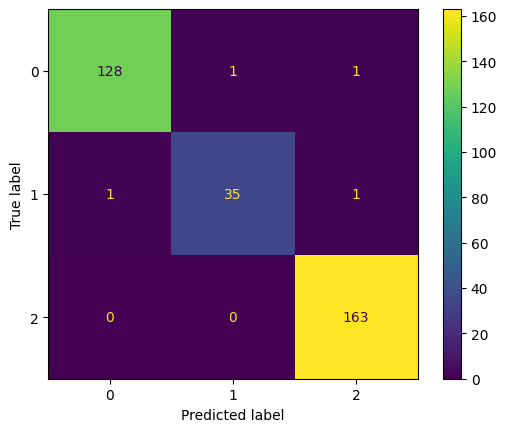

In [19]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# CNN 5

In [20]:
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.linear = nn.Linear(32*64*64, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.tanh(self.conv1(x))) # 256x256
        x = self.pool(F.tanh(self.conv2(x))) # 128x128
        x = self.pool(F.tanh(self.conv3(x))) # 64x64

        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [21]:
model5 = CNN5()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model5.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [22]:
results = []
for epoch in range(1, num_epochs+1):
    model5.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model5(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model5.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model5(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])
    if i%2 == 0:
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}")



Epoch 1/20: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]


Train Loss: 2.3195
Valid Loss: 1.1829


Epoch 2/20: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Train Loss: 0.6058
Valid Loss: 0.5382


Epoch 3/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.3552
Valid Loss: 0.4016


Epoch 4/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.2392
Valid Loss: 0.2070


Epoch 5/20: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Train Loss: 0.1154
Valid Loss: 0.1330


Epoch 6/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.0739
Valid Loss: 0.0874


Epoch 7/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.0639
Valid Loss: 0.1060


Epoch 8/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.0441
Valid Loss: 0.0653


Epoch 9/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.0243
Valid Loss: 0.0499


Epoch 10/20: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Train Loss: 0.0189
Valid Loss: 0.0693


Epoch 11/20: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


Train Loss: 0.0176
Valid Loss: 0.0596


Epoch 12/20: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Train Loss: 0.0304
Valid Loss: 0.0477


Epoch 13/20: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Train Loss: 0.0407
Valid Loss: 0.0605


Epoch 14/20: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Train Loss: 0.1148
Valid Loss: 0.0819


Epoch 15/20: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


Train Loss: 0.0473
Valid Loss: 0.0503


Epoch 16/20: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Train Loss: 0.0371
Valid Loss: 0.0493


Epoch 17/20: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


Train Loss: 0.0124
Valid Loss: 0.0333


Epoch 18/20: 100%|██████████| 24/24 [00:27<00:00,  1.17s/it]


Train Loss: 0.0103
Valid Loss: 0.0339


Epoch 19/20: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Train Loss: 0.0081
Valid Loss: 0.0297


Epoch 20/20: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Train Loss: 0.0073
Valid Loss: 0.0415


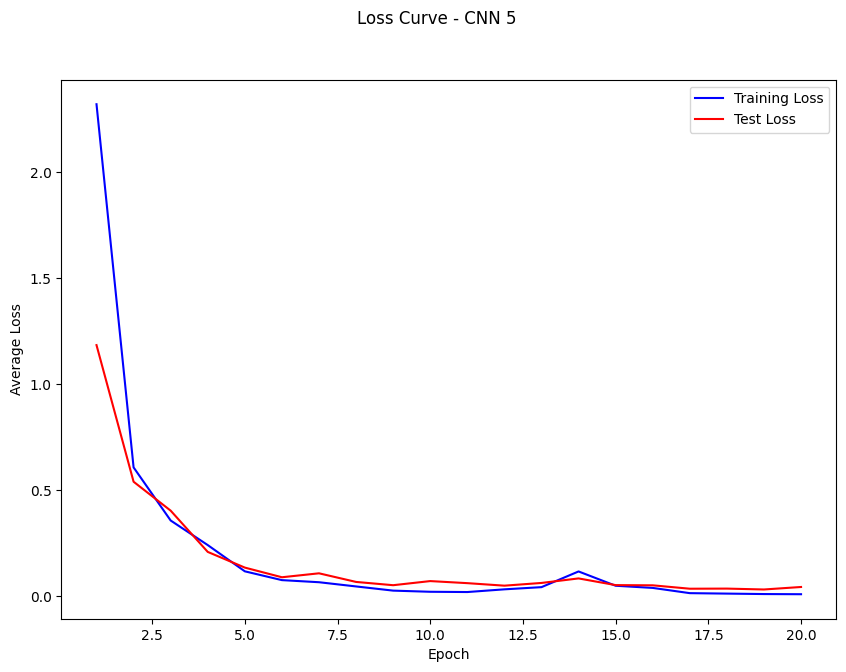

In [23]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - CNN 5')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [25]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model5(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9818181818181818
Overall ROC AUC: 0.9996616690200307
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       130
           1       1.00      0.86      0.93        37
           2       0.99      1.00      1.00       163

    accuracy                           0.98       330
   macro avg       0.99      0.95      0.97       330
weighted avg       0.98      0.98      0.98       330



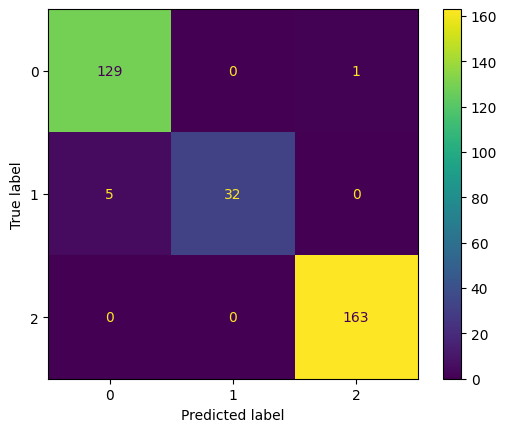

In [26]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))    

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()